In [1]:
import pandas as pd
import mc_processor
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import visualizing

import importlib
# importlib.reload(mc_processor)
importlib.reload(visualizing)

%matplotlib inline
%config InlineBackend.figure_format = 'png'



In [2]:
survey_year = str(2024)

In [3]:
# field1 = pd.read_csv(os.path.join(survey_year,'raw/field1/data.csv'), encoding='utf-8')
# field1.drop([q for q in field1.columns if q.startswith("BPC4")],axis=1)
# field2 = pd.read_csv(os.path.join(survey_year,'raw/field2/rvoter/data.csv'), encoding='utf-8')

# # join the two fields assuming reweights will produce minimal effects
# joined_data = pd.concat([field1,field2],axis=1)

In [4]:
# read results files

clarifier = "field2/rvoter/"
# clarifier = ""

codebook = pd.read_csv(os.path.join(survey_year,f'raw/levels_codebook.csv'), encoding='utf-8')
data = pd.read_csv(os.path.join(survey_year,f'raw/{clarifier}data.csv'), encoding='utf-8')
q_codebook = pd.read_csv(os.path.join(survey_year,f'raw/question_codebook.csv'), encoding='utf-8', index_col = 'qid')

# q_codebook into dict
q_codebook = q_codebook.to_dict().get('qidFull')

In [5]:
data.head(2)

,ResponseID,xdemAll,demZIP,BPC1_1,BPC1_2,BPC1_3,BPC1_4,BPC1_5,BPC2_1NET,BPC2_2NET,...,demLGBTQ1,xdemMarried,BPCxdem1,BPCxdem2,BPCxdem3,BPCxdem4,BPCxdem5,county_fips,demGender,wts
0,R_7IawucEjaAD7m62,1,62871,4,3,4,4,4,1,2,...,1,2,1,2,2,1,1.0,17059.0,2.0,0.074423
1,R_5PvmPKlU3zhT6Ip,1,15323,3,3,4,4,4,2,2,...,1,2,1,2,2,1,2.0,42125.0,2.0,0.282081


In [6]:
nulldata = pd.DataFrame(data.isnull().sum(),columns=["Sum_Null"]) ##2204 rows in 2024
nulldata.sort_values(by=["Sum_Null"],ascending=False,inplace=True)

# nulldata[nulldata["Sum_Null"]>0].head(20)

In [7]:
# all demo categories
for key in q_codebook:
    if "dem" in key:
        print(key)

xdemAll
demZIP
xdemGender
demAgeGeneration
xdemIdeo3
xdemInc3
xdemWhite
xdemHispBin
demBlackBin
demRaceOther
xdemReligion
xdemReligOther
xdemEvang
xdemUsr
xdemEmploy
xdemMilHH1
xdemBidenApprove
xdemBidenApprove2
demInsured
demInsType
demUnion
demLGBTQ1
xdemMarried
BPCxdem1
BPCxdem2
BPCxdem3
BPCxdem4
BPCxdem5
demGender3
demRVoter


In [8]:
## BPC17
mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo="xpid3",survey_year=survey_year,suppress_output=True)

PID: Dem (no lean)                        \
                       Social media platforms Your state government   
Far too much                         0.040733              0.030517   
Don't know/ No opinion               0.064629              0.100862   
Too much                             0.072320              0.057188   
Too little                           0.255689              0.311405   
Far too little                       0.270281              0.100301   
About the right amount               0.296349              0.399727   

                                                            \
                       Federal government Local government   
Far too much                     0.056283         0.029107   
Don't know/ No opinion           0.085461         0.117019   
Too much                         0.047978         0.064231   
Too little                       0.316584         0.287992   
Far too little                   0.117469         0.092892   
About the right amount           0.376225         0.408759   

                           PID: Ind (no lean)                        \
                       Social media platforms Your state government   
Far too much                         0.059244              0.050865   
Don't know/ No opinion               0.113059              0.126635   
Too much                             0.109571              0.046676   
Too little                           0.281739              0.292219   
Far too little                       0.218243              0.092169   
About the right amount               0.218144              0.391435   

                                                            \
                       Federal government Local government   
Far too much                     0.043217         0.040451   
Don't know/ No opinion           0.124612         0.149932   
Too much                         0.111250         0.071546   
Too little                       0.319297         0.249805   
Far too little                   0.118440         0.079751   
About the right amount           0.283184         0.408516   

                           PID: Rep (no lean)                        \
                       Social media platforms Your state government   
Far too much                         0.070419              0.049854   
Don't know/ No opinion               0.083314              0.111685   
Too much                             0.088147              0.056270   
Too little                           0.239069              0.286176   
Far too little                       0.260345              0.123545   
About the right amount               0.258706              0.372470   

                                                            
                       Federal government Local government  
Far too much                     0.082870         0.041733  
Don't know/ No opinion           0.103404         0.125199  
Too much                         0.073526         0.072084  
Too little                       0.283246         0.253705  
Far too little                   0.157398         0.117241  
About the right amount           0.299556         0.390038

In [9]:
##CONFIDENCE RATES

#save individual csvs for confidence by xpid3
confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

dfs = {}

for i in range(20, 24):
    df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
    dfs[confidence_keys[i]] = df
    df = df.map(lambda x: f"{x:.1%}")
    df.to_csv(f"2024/charts/BPC{i}.csv")


In [10]:
##PLOT OVERALL CONFIDENCE RATES

demo = None
question_number = 20

dfs = []
cols = []
for i in range(20,24):
    dfs.append(mc_processor.get_confidence_results(data,codebook,q_codebook,i,demo=None,suppress_output=True))#.map(lambda x: f"{x:.1%}"))
    cols.append(q_codebook[f"BPC{i}a"])

confidence = pd.concat(dfs, axis=1)
confidence.columns = cols

# visualizing.plot_overall_confidence(confidence)

In [11]:
##PLOT CONFIDENCE SPLIT SAMPLES
#split sample a - regular order
#split sample b - reverse order
#split sample c - random order

sample_dict = {"a":"regular order","b":"reverse order","c":"random order"}

all_dfs = []

for i in range(20,24):
    # store dfs for each sample
    q_dfs = []    
    for split_sample in ["a","b","c"]:
        question = "BPC"+str(i)+split_sample
    
        # get results for question by sample
        df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo=None,suppress_output=True)
        df.columns = [f"{sample_dict[split_sample]}"]
        q_dfs.append(df)
    
    # print(q_codebook[question]) # defaults to split sample c, but tested with other a/b/c combos and got same result (they rotated question order but didn't change question #)
    

    q_df = pd.concat(q_dfs, axis=1)

    q_df["deviation"] = q_df.std(axis=1)

    ## display df with formatted percents
    # display(q_df.iloc[:,0:3].map(lambda x: f"{x:.1%}"))

    all_dfs.append(q_df)

# visualizing.plot_split_sample(all_dfs, q_codebook)

# # get n for split samples
# for sample in ["a","b","c"]:
#     # for q in range(20,24):
#     q = 20
#     print(data[[f"BPC{q}{sample}"]].count())

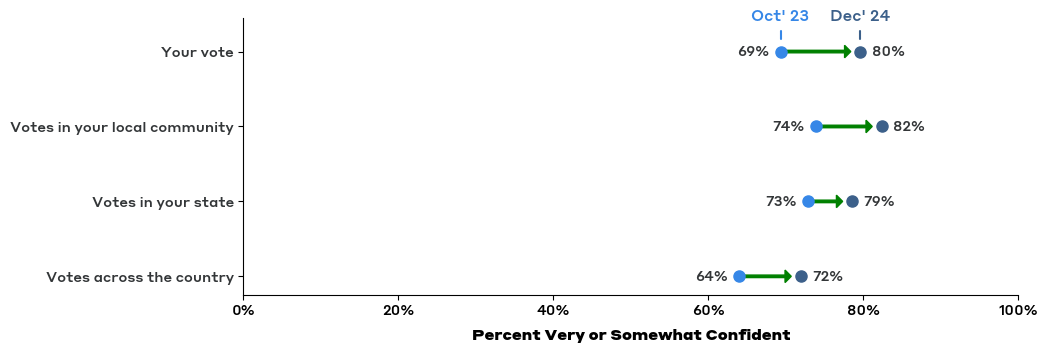

In [12]:
##DOT PLOT CHANGE IN CONFIDENCE 23 -> 24

importlib.reload(visualizing)

confidence2024 = confidence
confidence2023 = pd.read_csv("2023/confidence.csv",index_col=0)

# cols
confidence2023.columns = list(confidence_keys.values())
confidence2024.columns = list(confidence_keys.values())


confidence_23_24 = []
dfs= [confidence2023,confidence2024]
years  = ["2023","2024"]
for i in range(2):
    df = dfs[i].T
    df[years[i]] = df[["Very confident","Somewhat confident"]].sum(axis=1)
    df = df[[years[i]]]
    confidence_23_24.append(df)

confidence_23_24 = pd.concat(confidence_23_24,axis=1)

visualizing.dotplot(confidence_23_24,"confidence",start_tick_title = "Oct' 23", end_tick_title = "Dec' 24",xlabel='Percent Very or Somewhat Confident')


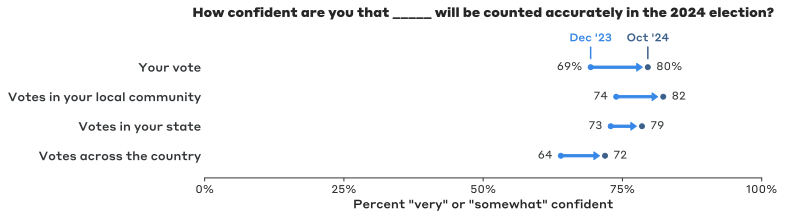

In [27]:
%config InlineBackend.figure_format = 'svg'

importlib.reload(visualizing)
visualizing.dotplot2(confidence_23_24,
                     'confidence_23_24.png',
                     start_tick_title = "Dec '23",
                     end_tick_title = "Oct '24",
                     xlabel='Percent "very" or "somewhat" confident',
                     title='How confident are you that _____ will be counted accurately in the 2024 election?')


In [41]:
# store demo results in processed folder
demos = ['xpid3','age']
questions = [f"BPC{i}" for i in range(1, 20)] + ['BPC24']

for demo in demos:
     for question in questions:
          mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=True)

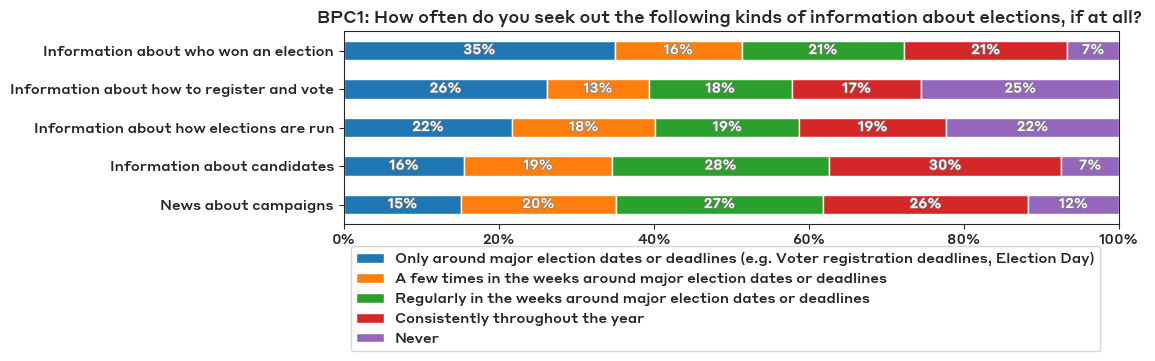

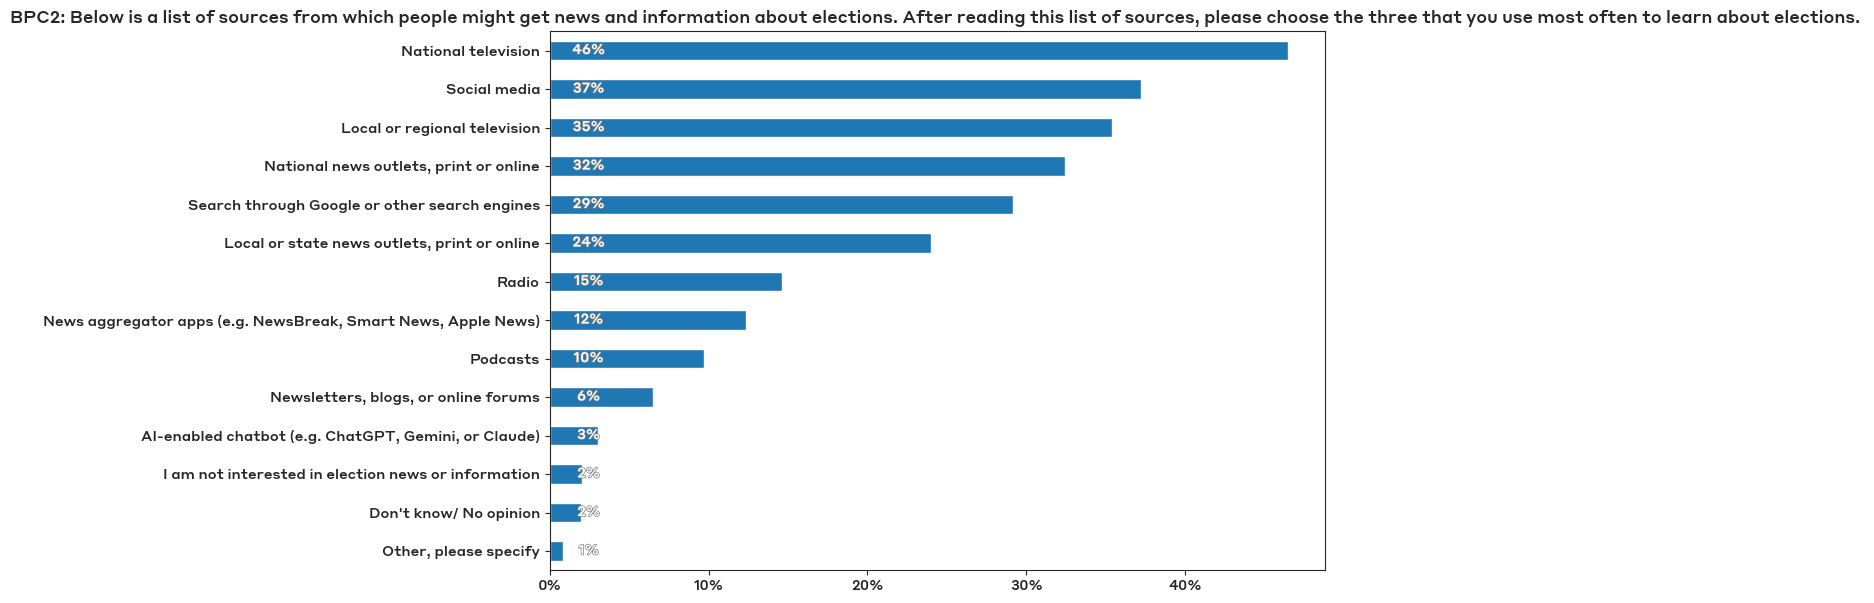

In [31]:
demo = None

questions = [f"BPC{i}" for i in range(1, 3)]

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)

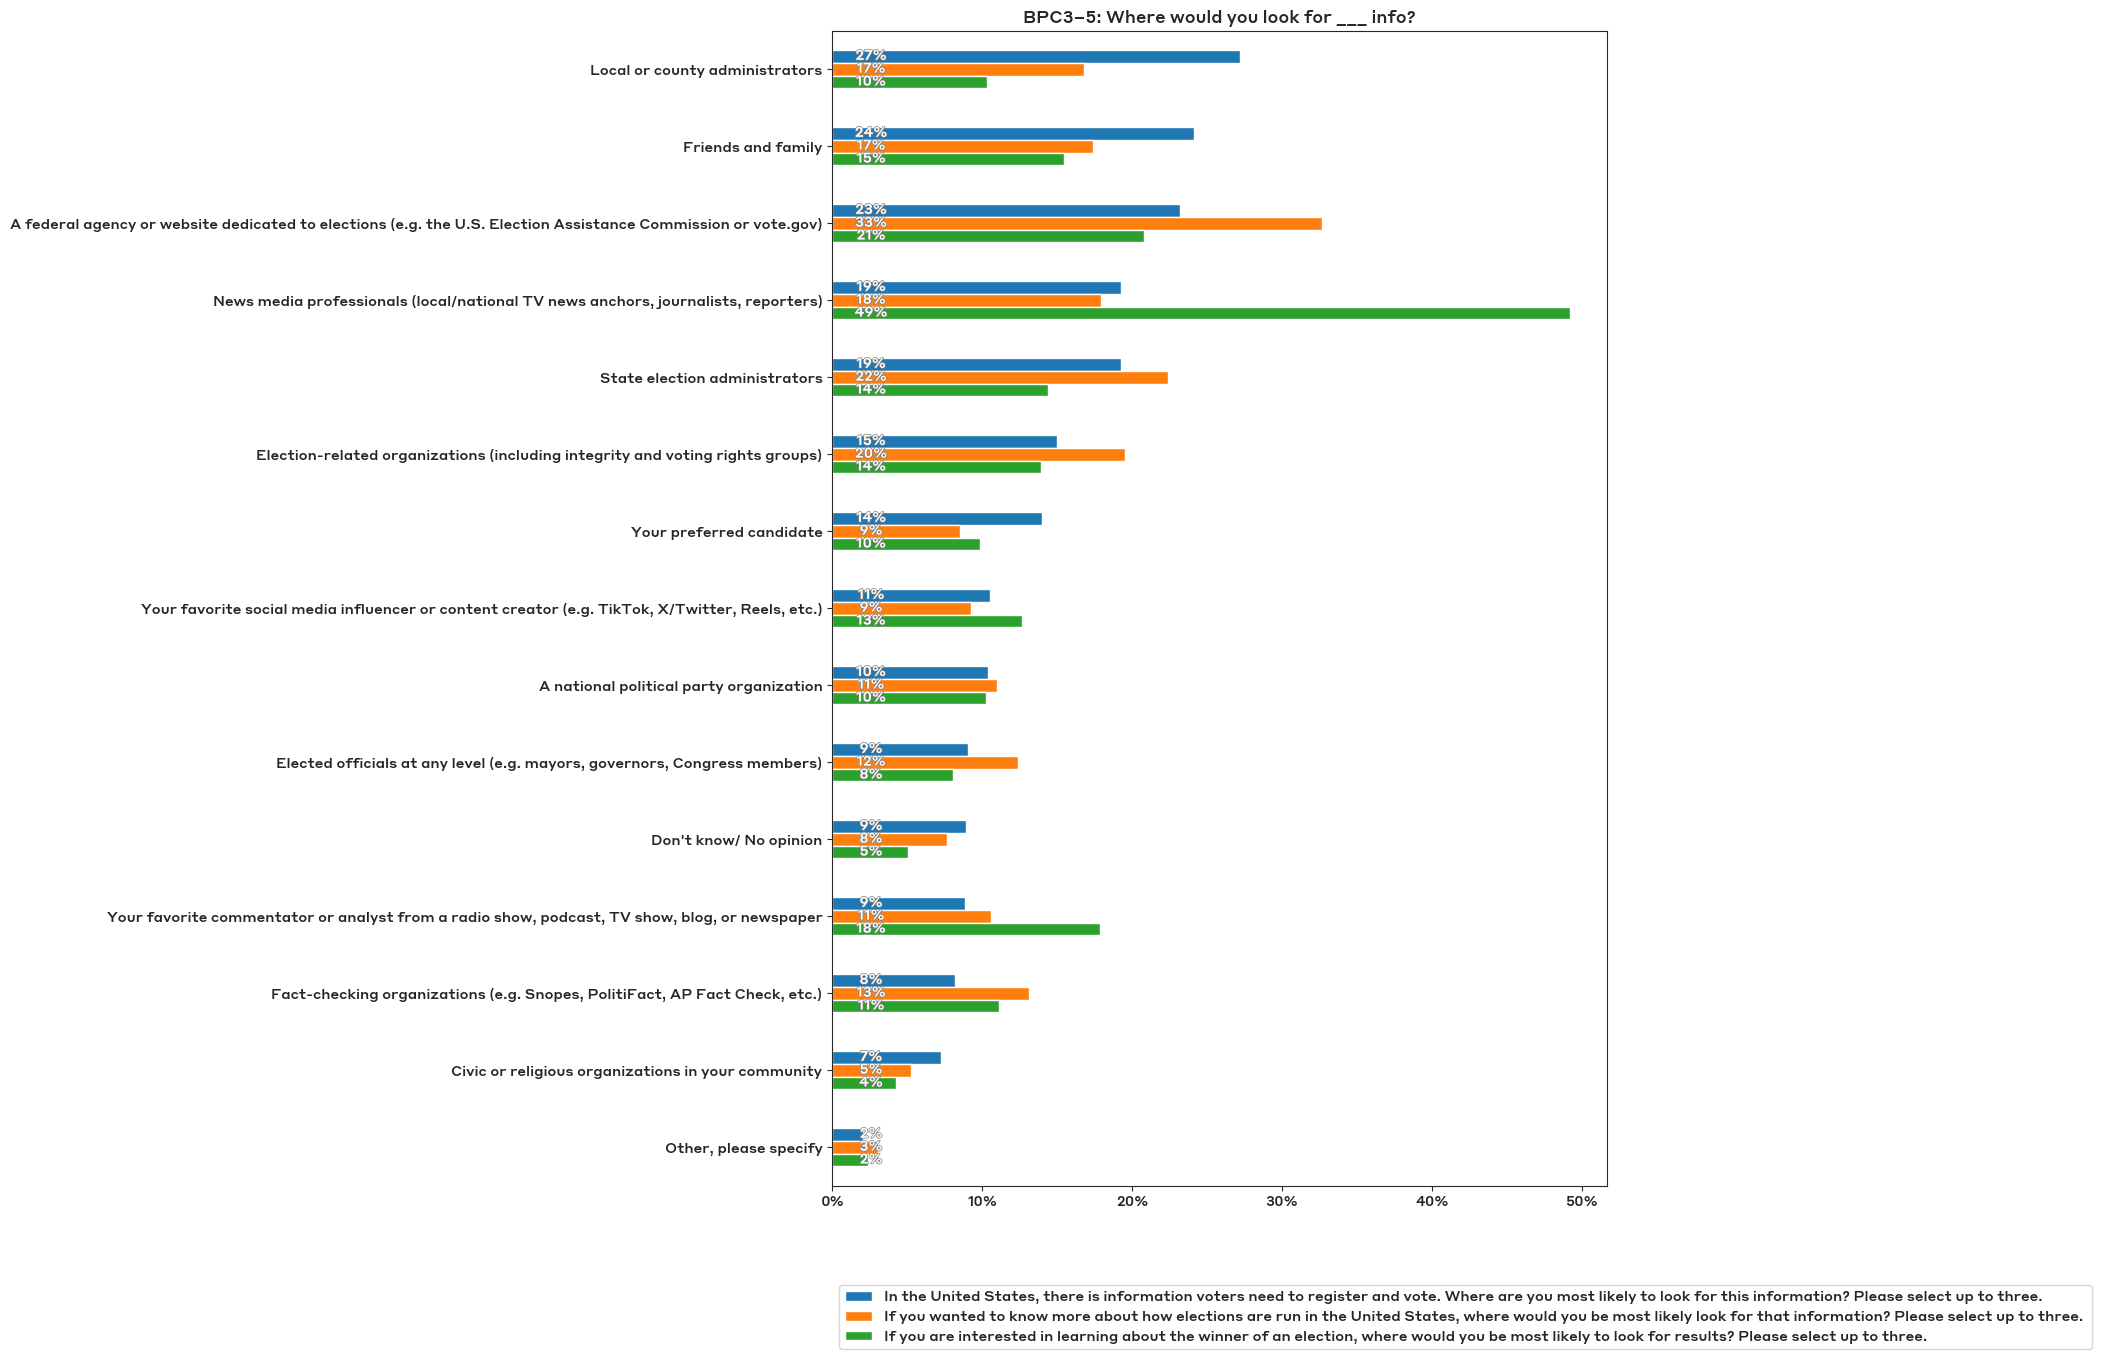

,"In the United States, there is information voters need to register and vote. Where are you most likely to look for this information? Please select up to three.","If you wanted to know more about how elections are run in the United States, where would you be most likely look for that information? Please select up to three.","If you are interested in learning about the winner of an election, where would you be most likely to look for results? Please select up to three."
Local or county administrators,27.2%,16.8%,10.3%
Friends and family,24.1%,17.4%,15.4%
A federal agency or website dedicated to elections (e.g. the U.S. Election Assistance Commission or vote.gov),23.2%,32.7%,20.8%
"News media professionals (local/national TV news anchors, journalists, reporters)",19.3%,17.9%,49.2%
State election administrators,19.3%,22.4%,14.4%
Election-related organizations (including integrity and voting rights groups),15.0%,19.6%,14.0%
Your preferred candidate,14.0%,8.5%,9.9%
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",10.5%,9.3%,12.7%
A national political party organization,10.4%,11.0%,10.3%
"Elected officials at any level (e.g. mayors, governors, Congress members)",9.0%,12.4%,8.1%


In [32]:
questions = [f"BPC{j}" for j in range(3, 6)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)
ax = visualizing.plot_question(final_df, 'BPC3–5', 'Where would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
display(final_df)
final_df.to_csv("2024/charts/info_topthree.csv")

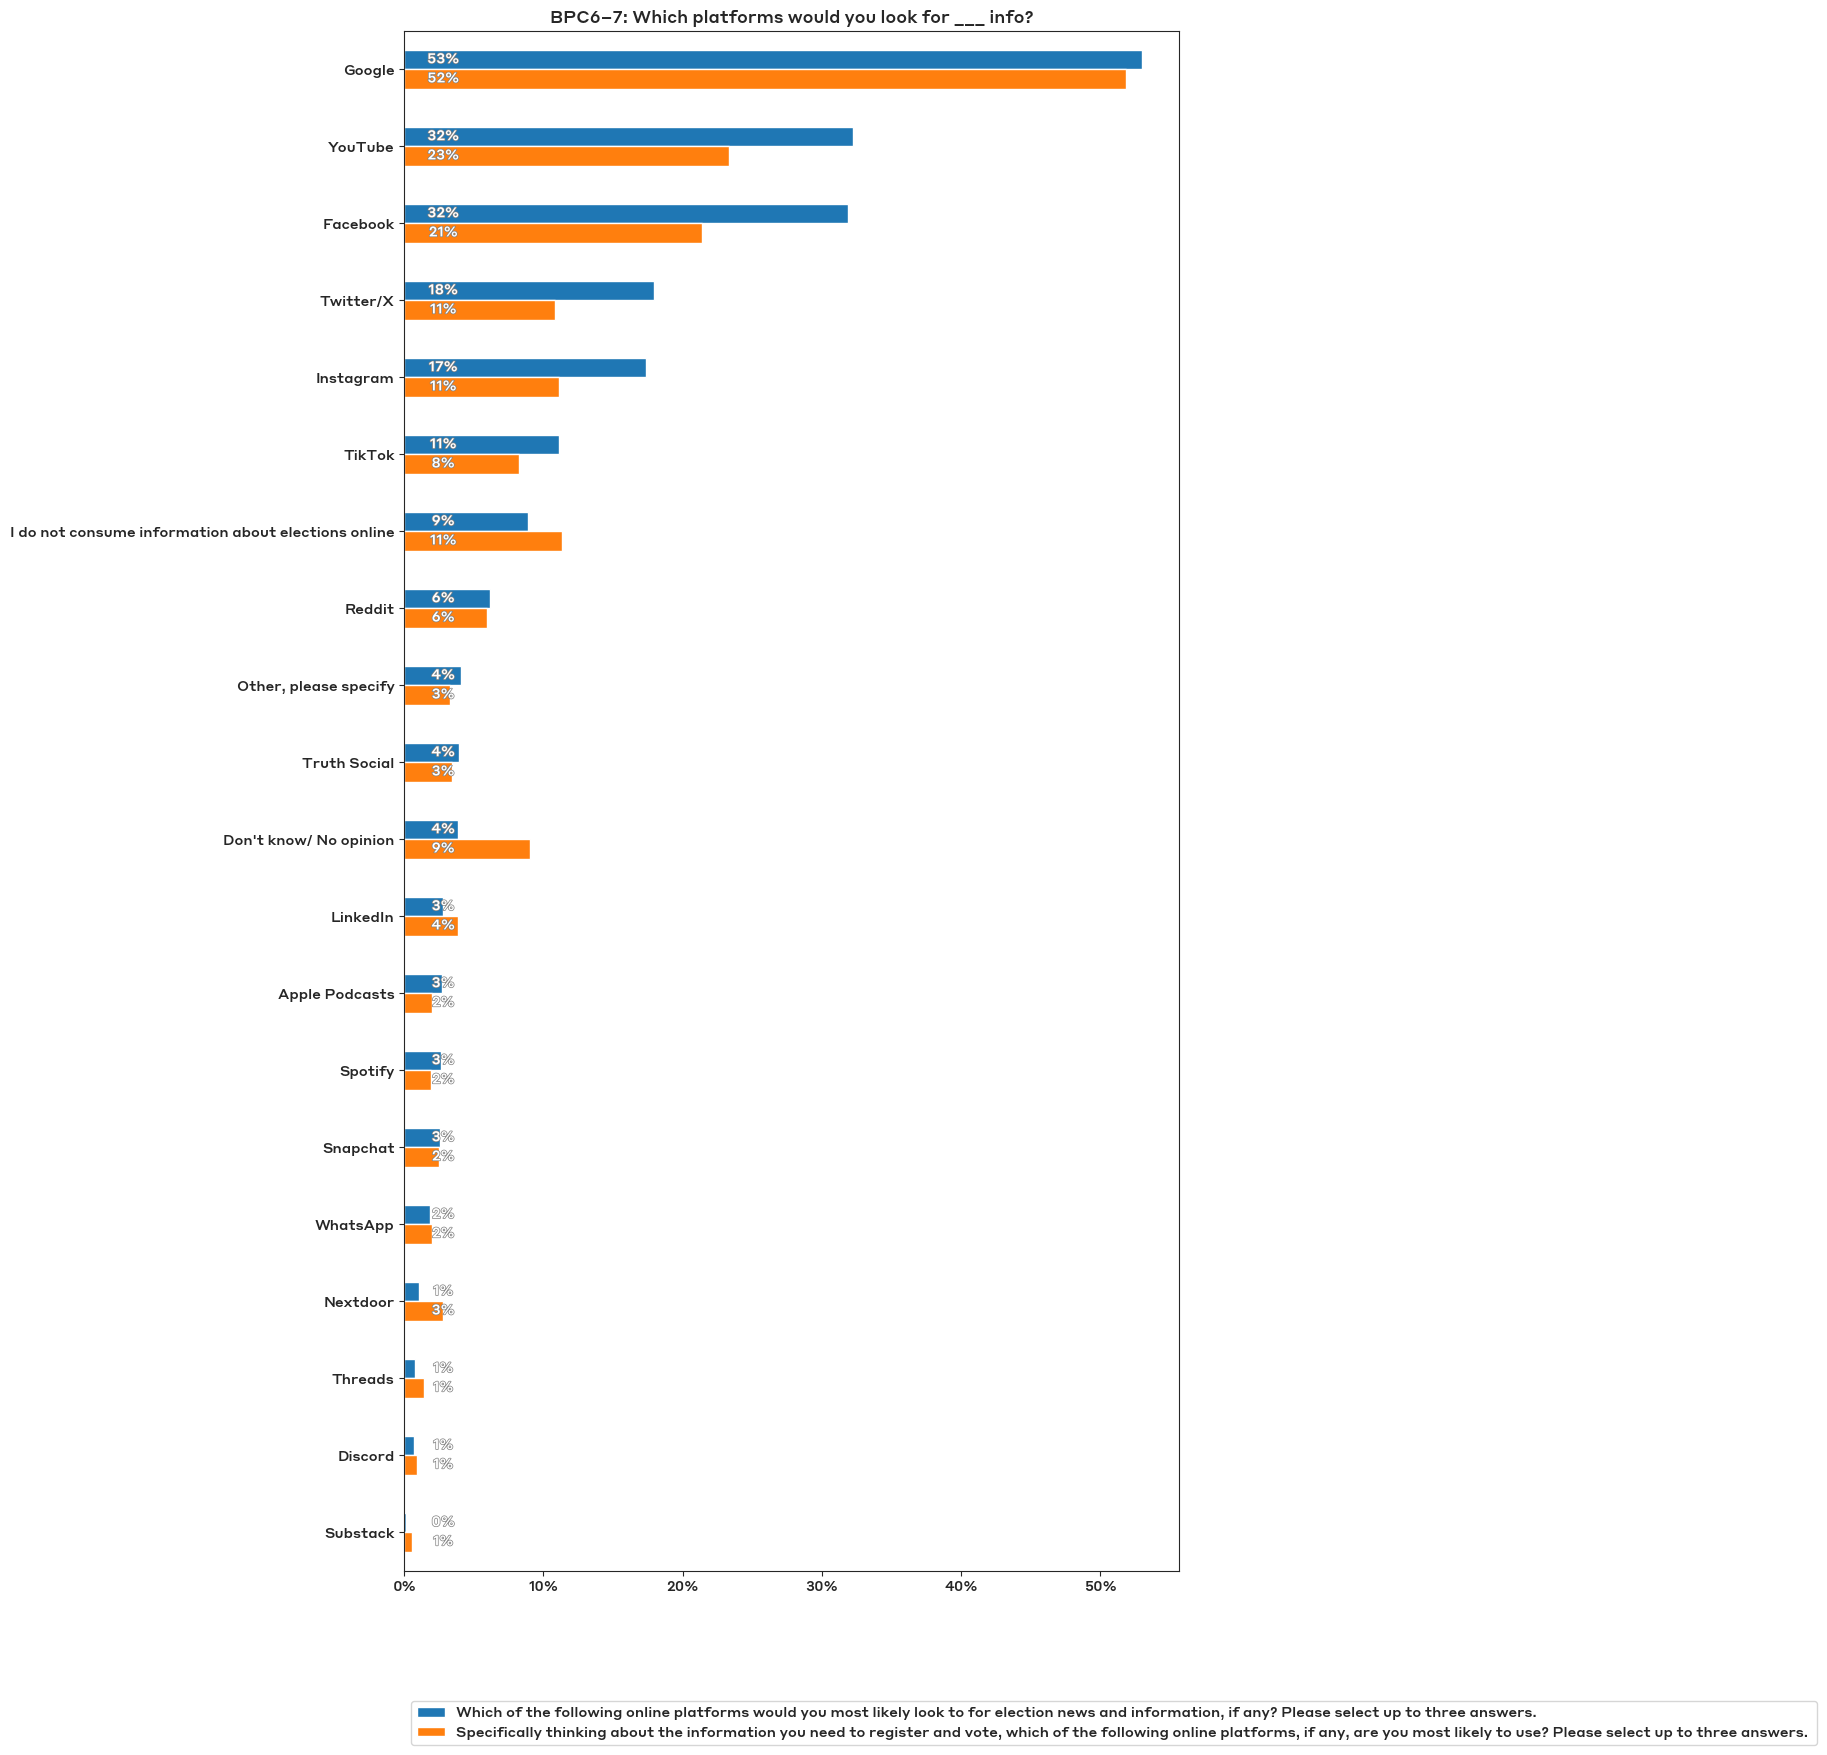

,"Which of the following online platforms would you most likely look to for election news and information, if any? Please select up to three answers.","Specifically thinking about the information you need to register and vote, which of the following online platforms, if any, are you most likely to use? Please select up to three answers."
Google,53.0%,51.9%
YouTube,32.3%,23.3%
Facebook,31.9%,21.4%
Twitter/X,17.9%,10.8%
Instagram,17.4%,11.1%
TikTok,11.1%,8.3%
I do not consume information about elections online,8.9%,11.4%
Reddit,6.1%,5.9%
"Other, please specify",4.1%,3.3%
Truth Social,3.9%,3.5%


In [33]:
questions = [f"BPC{j}" for j in range(6, 8)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)

ax = visualizing.plot_question(final_df, 'BPC6–7', 'Which platforms would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
display(final_df)
final_df.to_csv("2024/charts/online_platforms.csv")

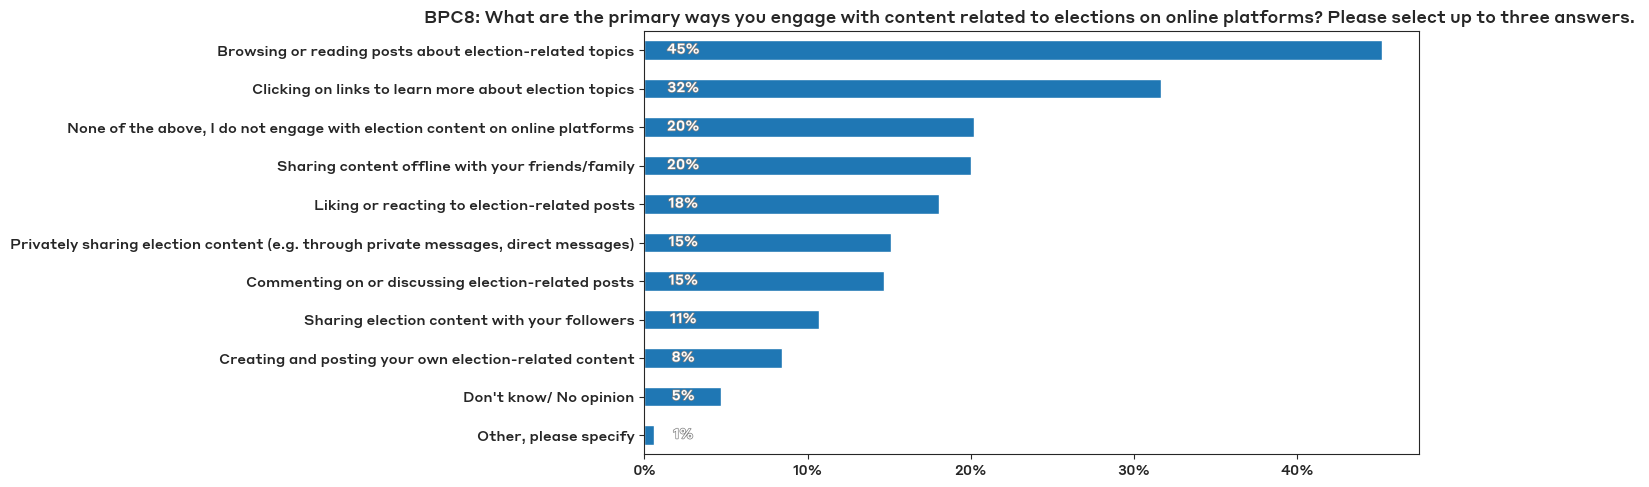

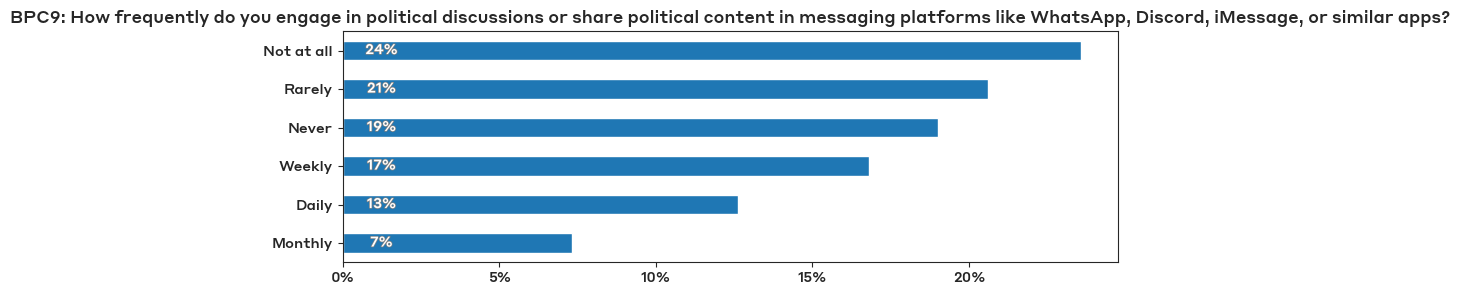

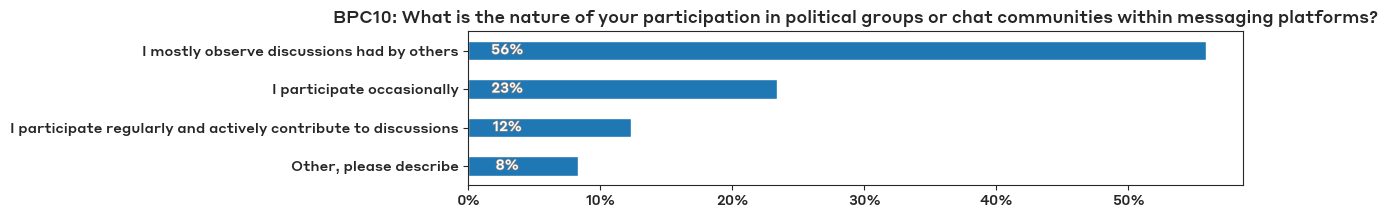

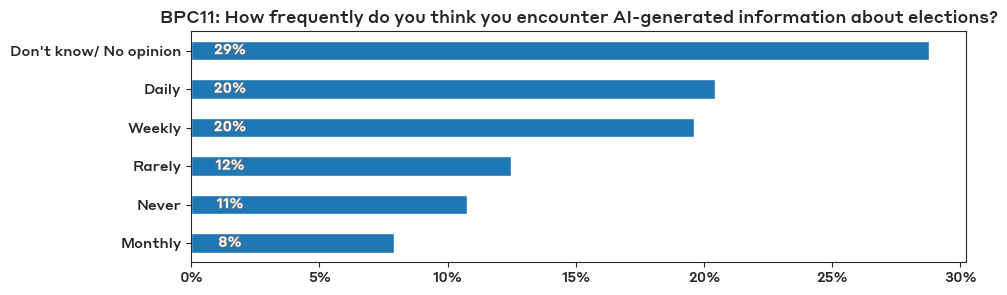

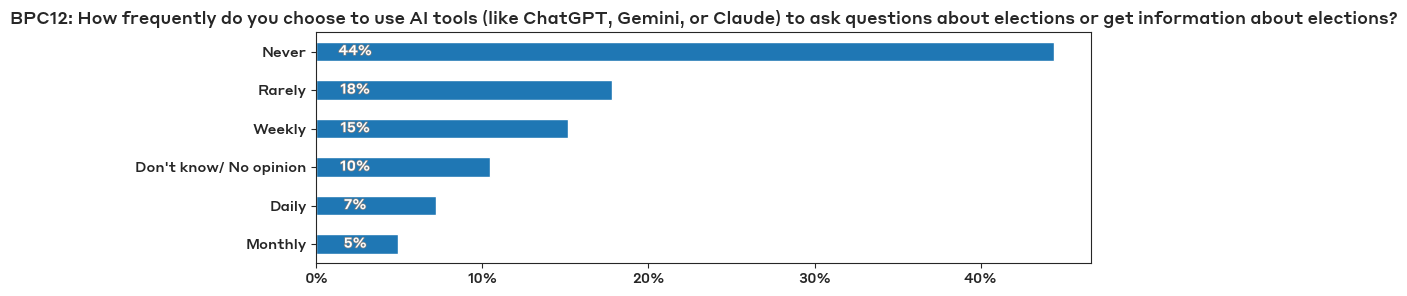

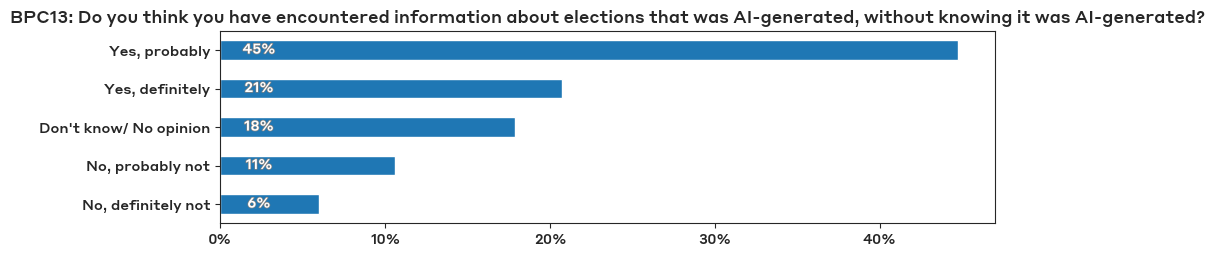

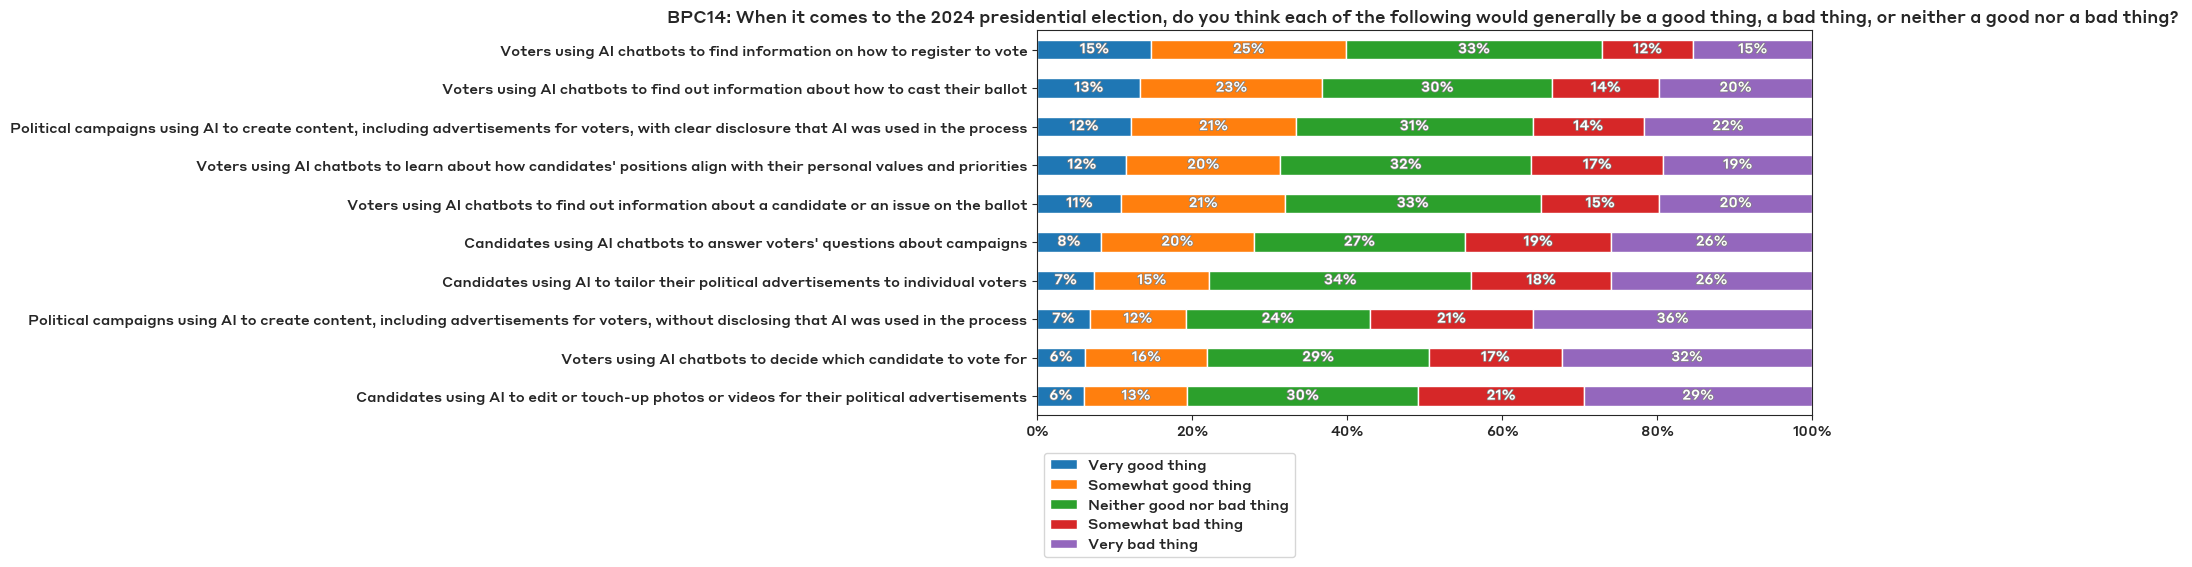

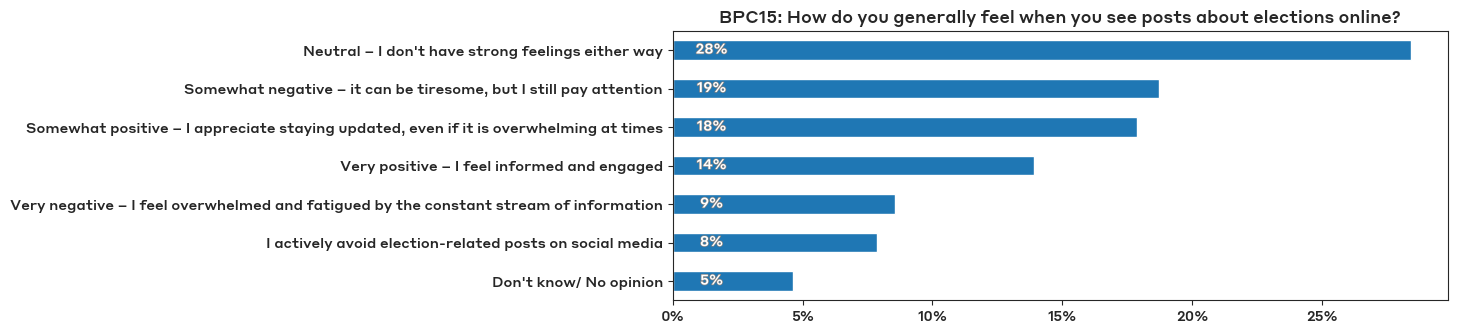

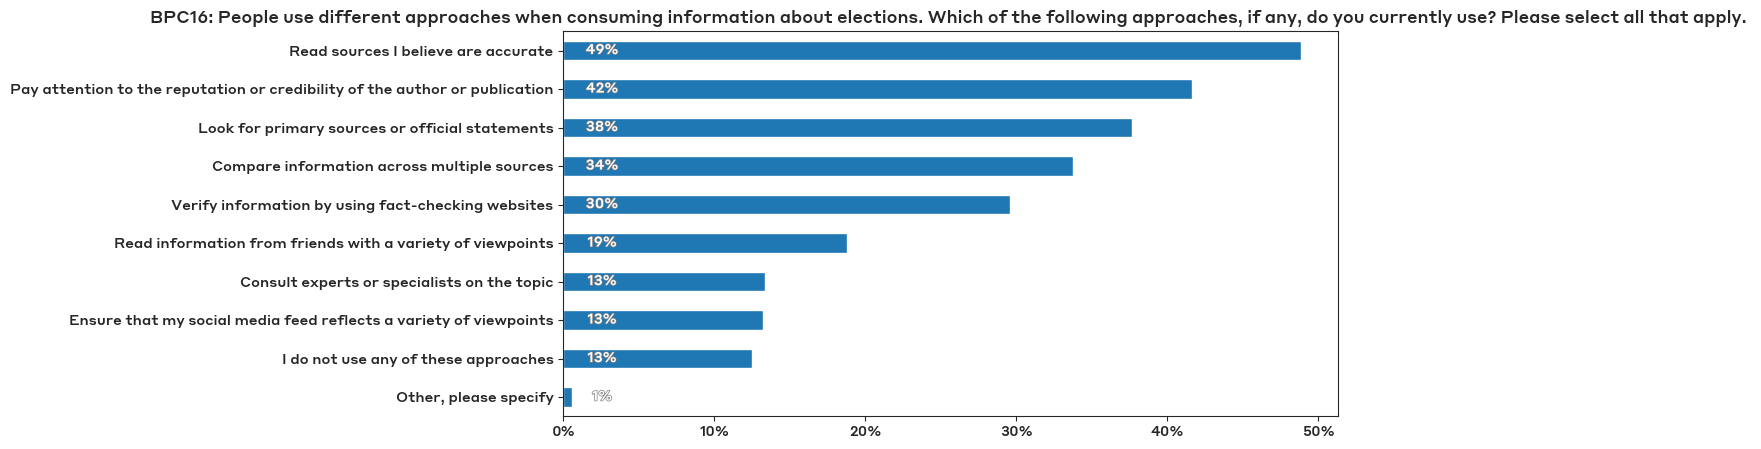

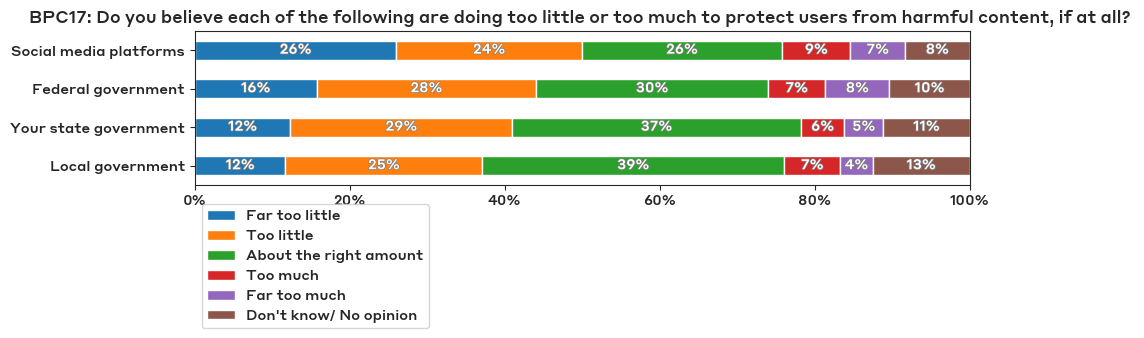

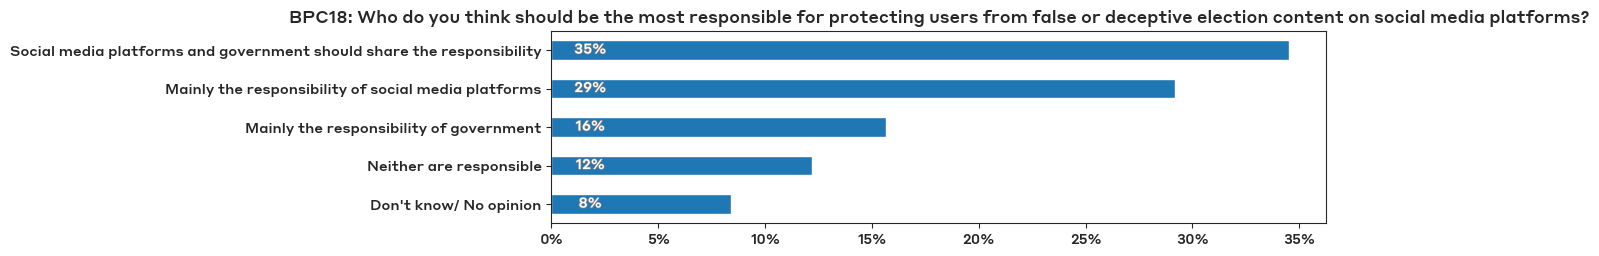

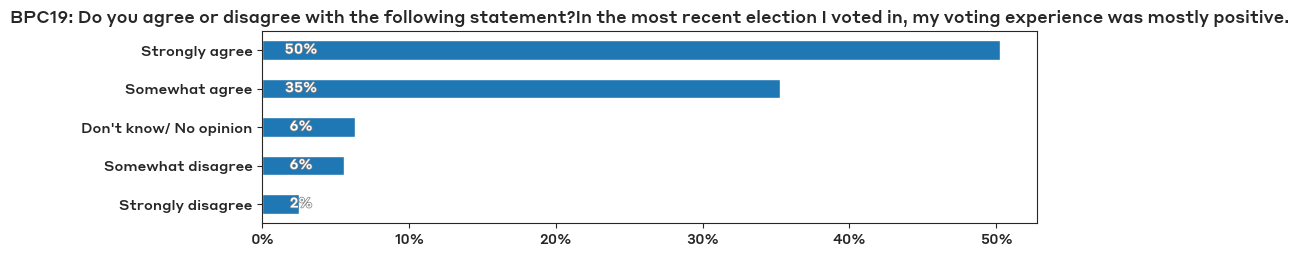

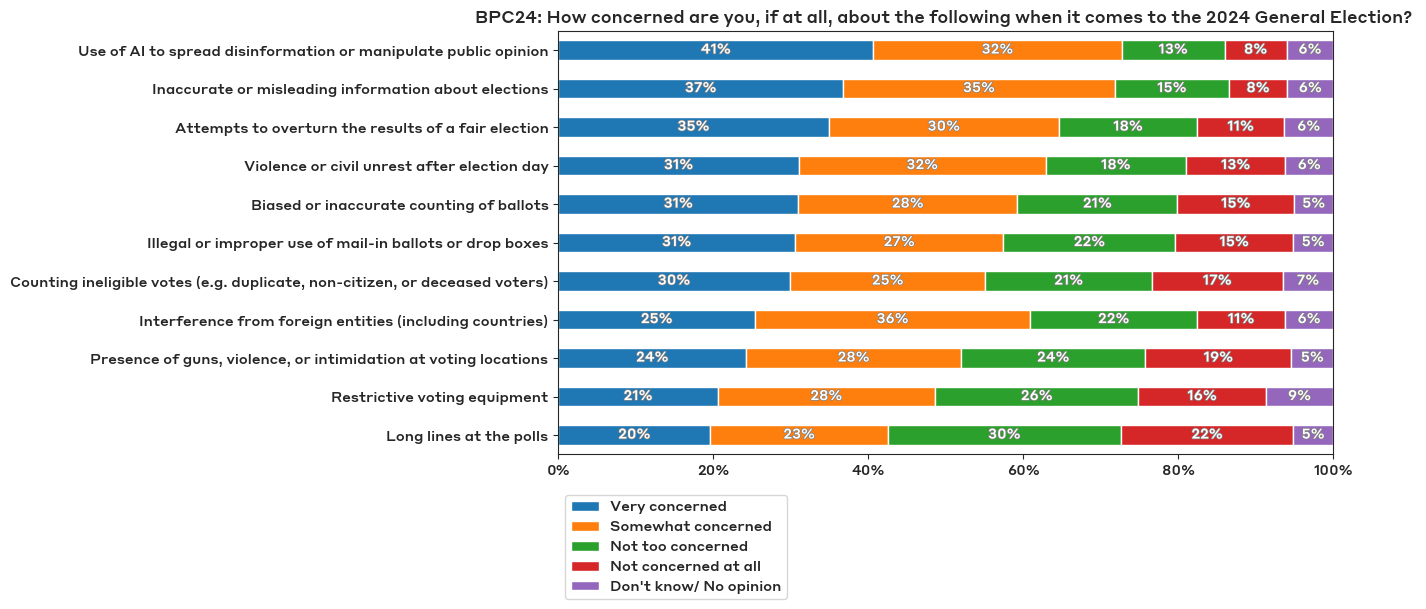

In [34]:
questions = [f"BPC{i}" for i in range(8, 20)] + ['BPC24']

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)


# Single use code / misc

In [35]:
# feelings23 = pd.read_csv("2023/feelings.csv",index_col=0)
# feelings23.index = [i.replace("it's", "it is").replace("/n", "/ N").replace("Somewhat negative– It","Somewhat negative – it") for i in feelings23.index]
# feelings23.columns = ["2023"]
# feelings = mc_processor.run_and_display(data,codebook,q_codebook,"BPC15",survey_year,demo,suppress_output=True)
# feelings = pd.concat([feelings23,feelings],axis=1)

# visualizing.dotplot(feelings,"feelings",start_tick_title="Dec' 23",end_tick_title="Oct' 24",xlabel="Percent of Respondents")

# ## stopped working on this one -- adjusting axes messes up other formatting, needs some more attention
# # don't think it's the best visual anyways -- want to consider something different

In [36]:
# ### VISUALIZE CONFIDENCE BY DEMO

# confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

# dfs = {}

# for i in range(20, 24):
#     df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
#     dfs[confidence_keys[i]] = df

# demo_confidence = []
# for q in dfs:
#     df = dfs[q].T
#     demo_confidence.append(pd.DataFrame(df[["Very confident","Somewhat confident"]].sum(axis=1),columns=[q]))

# demo_confidence = pd.concat(demo_confidence,axis=1)
    
# demo_confidence =demo_confidence.T
# demo_confidence = demo_confidence.map(lambda x: f"{x:.1%}")
# # demo_confidence.to_csv("2024/charts/xpid_confidence.csv")

# # bpc colors
# bpc_blue = '#3C608A'
# bpc_lightgray = '#d3d8d6'
# bpc_darkgray = '#333638'
# bpc_red = '#e43e47'
# bpc_lightblue = '#3687e7'
# bpc_lightyellow = '#f6fbc2'
# bpc_lightpurple = '#ddafec'
# bpc_pink='#f87fab'
# bpc_orange='#eec044'

# # Function to add data labels to bars
# def add_labels(bars):
#     for bar in bars:
#         width = bar.get_width()
#         ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width * 100:.0f}%', ha='left', va='center')

# # Set up the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define the positions for each bar
# bar_height = 0.2
# index = np.arange(len(demo_confidence))

# # Plot each group of bars
# bar1 = ax.barh(index - bar_height * 1.5, demo_confidence['PID: Dem (no lean)'], bar_height, label='PID: Dem (no lean)', color=bpc_blue)
# bar2 = ax.barh(index - bar_height / 2, demo_confidence['PID: Ind (no lean)'], bar_height, label='PID: Ind (no lean)', color=bpc_lightgray)
# bar3 = ax.barh(index + bar_height / 2, demo_confidence['PID: Rep (no lean)'], bar_height, label='PID: Rep (no lean)', color=bpc_red)
# bar4 = ax.barh(index + bar_height * 1.5, demo_confidence['overall'], bar_height, label='Overall', color=bpc_pink)

# # Call the function for each set of bars
# add_labels(bar1)
# add_labels(bar2)
# add_labels(bar3)
# add_labels(bar4)

# # Add labels and title
# ax.set_ylabel('Vote Confidence')
# ax.set_xlabel('Percentage (%)')
# ax.set_title('Confidence in Voting by Political ID')
# ax.set_yticks(index)
# ax.set_yticklabels(demo_confidence.index)

# # Add a legend
# ax.legend()

# # Display the plot
# plt.savefig("confidence_xpid.png")
# plt.show()